### *EN3160 Assignment 02 - Fitting and Alignment*

#### *1. Detect and Draw Circles Using Blob Detection*

Range of  2 - 40  sigma values are used.
The maximum estimated standard deviation:  50.91168824543143


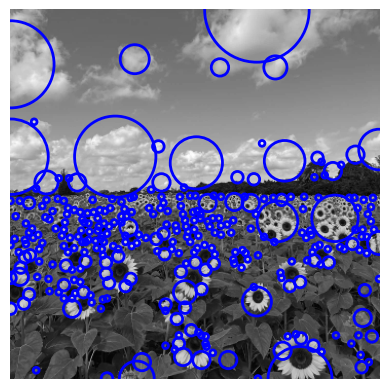

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import skimage
from skimage.feature import blob_log

# Loading the image
img_orig = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)

blobs = blob_log(img_gray, min_sigma=2, max_sigma=40, num_sigma=20, threshold=.1)
a = max(blobs[:, 2])
blobs[:, 2] = blobs[:, 2] * math.sqrt(2)
b = max(blobs[:, 2])

fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')
ax.axis('off')

for b in blobs:
    y, x, r = b
    c = plt.Circle((x, y), r, color='blue', linewidth=2, fill=False)
    ax.add_patch(c)
    

print('Range of ', 2, '-', 40, ' sigma values are used.')    
print('The maximum estimated standard deviation: ', max(blobs[:, 2]))

plt.show()

#### *2. Line & Circle Estimation Using RANSAC Algorithm*

-----------------------------Implement Line Estimation--------------------------------

Iteration:  0
Line best error:  8.506101811807476
Best line indices:  [59 98]
Best model for the line:  [0.72191064 0.69198629 1.28314755]
Total number of inliers:  43

Iteration:  19
Line best error:  8.353536820972012
Best line indices:  [67 68]
Best model for the line:  [0.72557603 0.68814201 1.31678517]
Total number of inliers:  43

------------------------------------Implement Circle Estimation----------------------------------------------
Number of inliers:  43
Number of remnants:  57

Iteration:  6
Circle best error:  5.93591383827253
Best circle indices:  [14 37  6]
Best model for circle:  [ 2.19692814  3.16787222 10.03659564]
Total number of inliers:  37

Iteration:  10
Circle best error:  5.799824086618864
Best circle indices:  [ 6 11 18]
Best model for circle:  [ 1.99191944  3.38481927 10.22372869]
Total number of inliers:  38

Iteration:  14
Circle best error:  5.691516430390489
Best cir

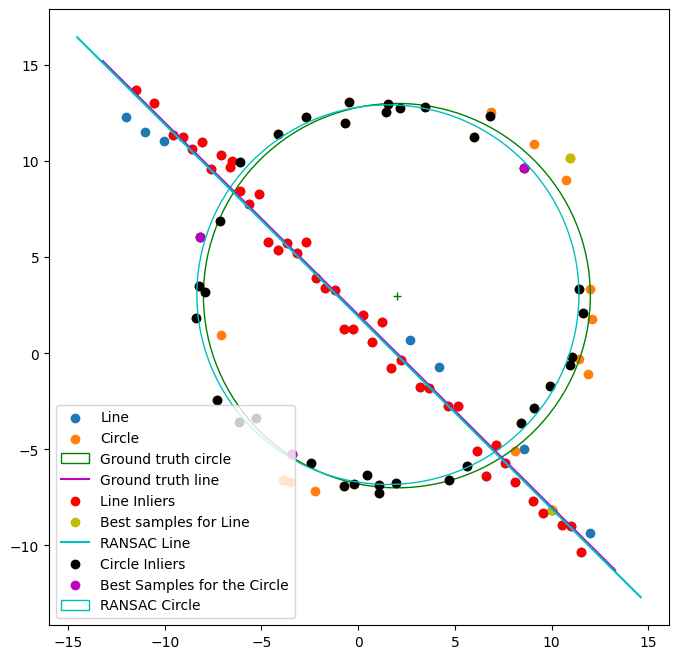

In [2]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed (0)
N = 100
half_n = N//2

r = 10
x0_gt, y0_gt = 2, 3     # Center
s = r/16

t = np.random.uniform (0, 2*np.pi ,half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r+n)*np.cos(t), y0_gt + (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1 ), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n ,1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))     # All points

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_line[:, 0], X_line [:, 1], label= 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label= 'Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()




# Implement line estimation usig RANSAC
print('-----------------------------Implement Line Estimation--------------------------------')

N = X.shape[0]      # Number of data points

def cons(p):
    # Define the constraint
    return (p[0]**2) + (p[1]**2) - 1

constraint = ({'type':'eq', 'fun':cons})

def total_LSE(x, indices):
    # Define total least square error for a line
    a, b, d = x[0], x[1], x[2]
    
    error = np.square(a*X[indices, 0] + b*X[indices, 1] - d)
    total_error = np.sum(error)
    
    return total_error

def consensus_set(X, x, threshold):
    # Define the consensus set
    a, b, d = x[0], x[1], x[2]
    
    error = np.abs(a*X[:, 0] + b*X[:, 1] - d)
    return (error < threshold)


# Define RANSAC parameters
max_iterations = 100
line_data_points = 0.4*N
line_threshold = 1.
line_best_error = np.inf
line_sample = 2
t = 0

best_model = []
inliers = []
line_indices = []
best_line_inliers = []

while (t < max_iterations):
    # Randomly selects points
    line_indices = np.random.randint(0, N, line_sample)
    
    # Initial guess
    x0 = np.array([1, 1, 0])
    # Minimize the total least square error
    res = minimize(total_LSE, x0=x0, args=(line_indices), tol=1e-6, constraints=constraint)
    # Find the consensus set for the line
    inliers = consensus_set(X, res.x, line_threshold)
    
    if np.sum(inliers) > line_data_points:
        x0 = res.x
        # Refit the model
        res = minimize(total_LSE, x0=x0, args=(inliers), tol=1e-6, constraints=constraint)
        
        if res.fun < line_best_error:
            print('\nIteration: ', t)
            line_best_error = res.fun
            best_line_indices = line_indices
            best_model = res.x
            best_line_inliers = inliers
            
            print('Line best error: ', res.fun)
            print('Best line indices: ', line_indices)
            print('Best model for the line: ', res.x)
            print('Total number of inliers: ', np.sum(inliers))
            
    t += 1
    
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='r', label='Line Inliers')
ax.scatter(X[line_indices, 0], X[line_indices, 1], color='y', label='Best samples for Line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model[1]*x_ + best_model[2]) / best_model[1]
plt.plot(x_, y_, color='c', label='RANSAC Line')
ax.legend()



# Implement Circle Estimation Using RANSAC
print('\n------------------------------------Implement Circle Estimation----------------------------------------------')
print('Number of inliers: ', np.sum(best_line_inliers))

line_outliers = np.where(best_line_inliers==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('Number of remnants: ', len(remnants))

def c_total_LSE(x, indices):
    # Define total least square error for a circle
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    
    error = (np.sqrt((x1-x0)**2 + (y1-y0)**2) - r)**2
    return np.sum(error)

def c_consensus_set(remnants, x, threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    
    return distances < threshold

c_threshold = 1.
max_iterations = 100
c_best_model = []
c_best_inliers = []
c_best_indices = []

c_best_error = np.inf
c_sample = 3
c_num_data = 35
t = 0

while (t < max_iterations):
    c_indices = np.random.randint(0, len(remnants), c_sample)
    
    # Initial guess
    x0 = np.array([0, 0, 0])
    # Minimize the error
    res = minimize(c_total_LSE, x0, args=c_indices, tol=1e-6)
    # Find the consensus set
    c_inliers = c_consensus_set(remnants, res.x, c_threshold)
    
    if np.sum(c_inliers) > c_num_data:
        x0 = res.x
        # Refit the model
        res = minimize(c_total_LSE, x0=x0, args=(c_inliers), tol=1e-6)
        
        # region
        if res.fun < c_best_error:
            print('\nIteration: ', t)
            c_best_error = res.fun
            c_best_indices = c_indices
            c_best_model = res.x
            c_best_inliers = c_inliers
            
            print('Circle best error: ', c_best_error)
            print('Best circle indices: ', c_best_indices)
            print('Best model for circle: ', c_best_model)
            print('Total number of inliers: ', np.sum(c_best_inliers))
        #endregion
            
    t += 1
    
ax.scatter(remnants[c_best_inliers, 0], remnants[c_best_inliers, 1], color='k', label='Circle Inliers')
ax.scatter(remnants[c_best_indices, 0], remnants[c_best_indices, 1], color='m', label='Best Samples for the Circle')
circle = plt.Circle((c_best_model[0], c_best_model[1]), c_best_model[2], color='c', fill=False, label='RANSAC Circle')
ax.add_patch(circle)
ax.legend()


##### *(d) If we fit the circle first, the algorithm will create a model that fits the circular points well. But it won't be able to capture the remnants for line model effectively. So, when we try to obtain line parameters that need to account for these remnants, it would be difficult. So, in RANSAC-based models, it is better to fit much simpler model (like lines) first, and then hndle the remaining points (remnants) with more complex models.*

#### *3. Image Superimposing*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: (768, 1024, 3)
Flag shape: (150, 225, 3)
Selected Points: [(281, 246), (272, 446), (503, 292), (500, 461)]
Homographic Matrix: 
[[-6.88614114e-02  2.10221427e+00  2.81000000e+02]
 [ 8.41564663e-01  6.67872567e-01  2.46000000e+02]
 [-1.06108130e-04  1.23700651e-03  1.00000000e+00]]


Text(0.5, 1.0, 'Image of a Building Superimposed with the United Kingdom Flag')

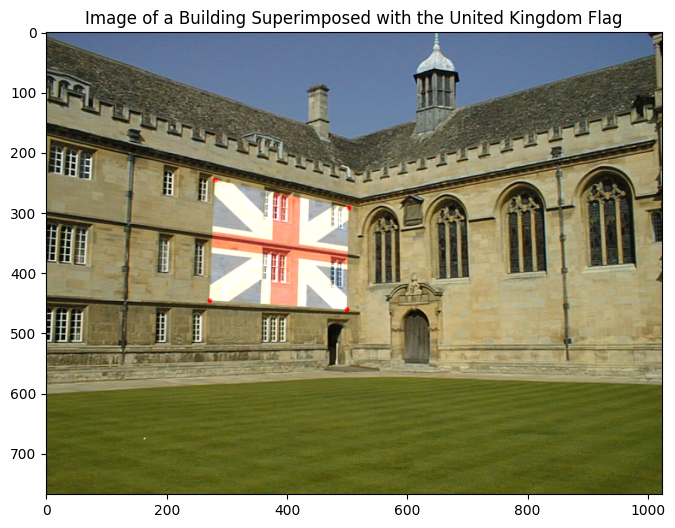

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def point_selection(action, x, y, flags, param):
    # Define mouse click occassions to gather point coordinates for warp the image
    
    global clicked_points

    if action == cv.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        cv.circle(base_img, (x, y), 4, (0, 0, 255), -1)
        
        # Show the selected positions on the base image in a second window
        # (Simply close this second window and continue point selection in the first window)
        cv.imshow('Image', base_img)


base_img = cv.imread('building.jpg')
adding_img = cv.imread('uk_flag.png')

# Normalize the pixel values into [0, 1] range
base_img = base_img.astype(np.float32) / np.iinfo(base_img.dtype).max
adding_img = adding_img.astype(np.float32) / np.iinfo(adding_img.dtype).max

# Display the base image to implement point selection step
cv.imshow('Base Image', base_img)
cv.setMouseCallback('Base Image', point_selection)

# Store the clicked points in the image
clicked_points = []

# Point Selection Step
# Select four points in the order of left top, left bottom, right top and right bottom
while len(clicked_points) < 4:
    cv.waitKey(1)
cv.destroyAllWindows()

print("Image shape:", base_img.shape)
print("Flag shape:", adding_img.shape)
print("Selected Points:", clicked_points)

# Define source and destination points for homography
destination_points = np.array(clicked_points).astype(np.float32)
h2, w2 = adding_img.shape[:2]
source_points = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]])

# Define the homographic matrix
H = cv.getPerspectiveTransform(source_points, destination_points)
print('Homographic Matrix: ')
print(H)

# Warping the adding image with the homography
warped_img = cv.warpPerspective(adding_img, H, (base_img.shape[1], base_img.shape[0]))

# Superimposing the warped image with the base image
supimp_img = cv.addWeighted(base_img, 1, warped_img, 0.5, 0)

plt.figure(figsize=(12,6))
plt.imshow(cv.cvtColor(supimp_img, cv.COLOR_BGR2RGB))
plt.title('Image of a Building Superimposed with the United Kingdom Flag')

#### *4. Image Stiching*

((< cv2.DMatch 0000028604A9E670>, < cv2.DMatch 000002867AD45E50>), (< cv2.DMatch 00000286077FBF30>, < cv2.DMatch 00000286077FA690>), (< cv2.DMatch 00000286077FA290>, < cv2.DMatch 00000286077FAA30>), (< cv2.DMatch 00000286077F9D30>, < cv2.DMatch 00000286077FA4B0>), (< cv2.DMatch 00000286077F9E50>, < cv2.DMatch 00000286077FACF0>))


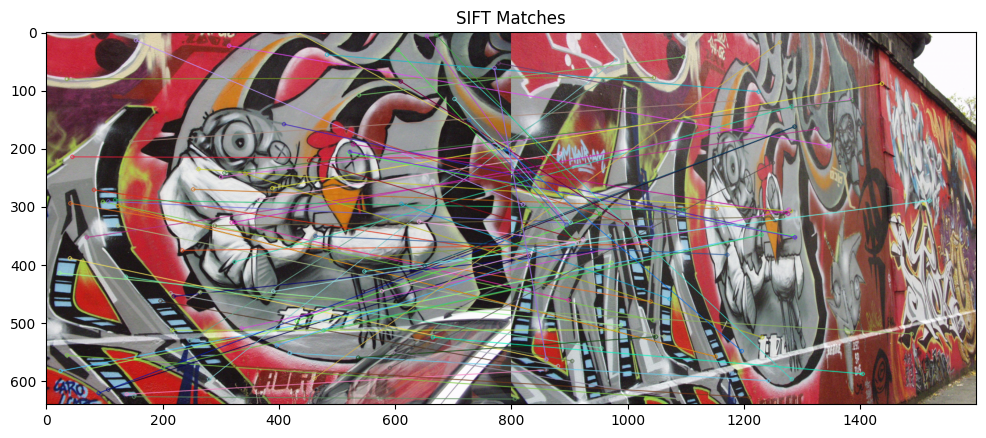

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1_rgb = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5_rgb = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Create the Brute-Force Matcher
bf = cv.BFMatcher()

# Find SIFT keypoints and descriptors for images
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

# Match descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)
print(matches[:5])

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < (0.75*n.distance):
        good_matches.append(m)

# Draw the matches
matched_img = cv.drawMatches(img1_rgb, keypoints1, img5_rgb, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display or save the matched image
plt.figure(figsize=(12,6))
plt.imshow(matched_img)
plt.title('SIFT Matches')
plt.show()


Computed Homography Matrix:
[[ 1.37108549e+00 -1.18271447e-02 -3.13665483e+02]
 [-5.71871878e-01  6.64062465e-01  1.96830689e+02]
 [-1.10130436e-03  2.34084404e-04  1.00000000e+00]]


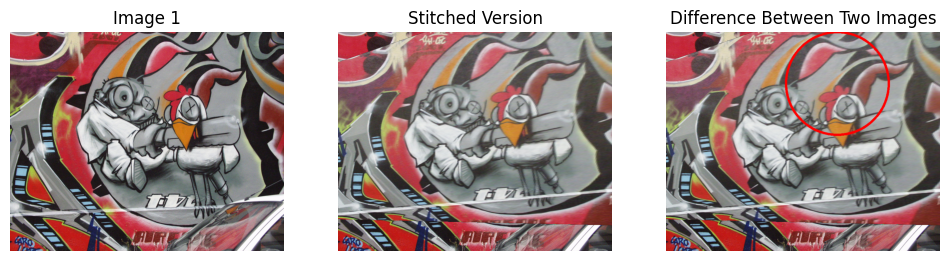

In [77]:
# Compute the Homography Matrix using RANSAC
from scipy import linalg

def calDistance(point_1, point_2, homography):
    # Compute the Euclidean distance between two points
    
    p1 = np.array([point_1[0], point_1[1], 1])
    p2 = np.array([point_2[0], point_2[1], 1])
    
    estimated_p2 = np.dot(homography, p1.T)
    estimated_p2 = (1 / estimated_p2[2]) * estimated_p2
    
    return np.linalg.norm(p2.T - estimated_p2)

def RANSAC(point_1, point_2, threshold=40, iterations=100, min_inlier_count=10):
    num_inliers = 0
    selected_inliers = None
    best_homography = None
   
    points = np.hstack((point_1, point_2))
    
    for _ in range(iterations):
        np.random.shuffle(points)
        p1, p1_rem, p2, p2_rem = points[:4, :2], points[4:, :2], points[:4, 2:], points[4:, 2:]
        
        homography = cv.findHomography(p1, p2)[0]
        
        # Initialize an empty list to store inliers
        inliers = []
        
        # Iterate through corresponding points and calculate distances
        for i in range(len(p1_rem)):
            if calDistance(p1_rem[i], p2_rem[i], homography) < threshold:
               inliers.append((p1_rem[i], p2_rem[i]))
                
        if len(inliers)>num_inliers and len(inliers)>=min_inlier_count:
            num_inliers = len(inliers)
            selected_inliers = np.array(inliers)
            best_homography = homography
            
    return best_homography

# Create a SIFT detector
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.08, edgeThreshold=12, sigma=0.9)

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

# Create a Brute-Force Matcher
bf_matcher = cv.BFMatcher()

# Perform keypoint matching
matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)

good_matches = []
keypoints1_matched = []
keypoints2_matched = []

# Apply ratio test to select good matches and corresponding keypoints
for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good_matches.append(match1)
        keypoints1_matched.append(keypoints1[match1.queryIdx].pt)
        keypoints2_matched.append(keypoints2[match1.trainIdx].pt)
        
# Convert lists to NumPy arrays for further processing
good_matches = np.array(good_matches)
keypoints1_matched = np.array(keypoints1_matched)
keypoints2_matched = np.array(keypoints2_matched)

# calculate homography using RANSAC
computed_homography = RANSAC(keypoints2_matched, keypoints1_matched)

print("Computed Homography Matrix:")
print(computed_homography)

H = np.array(computed_homography)

# warp first image using the perspective transformation matrix H
img_warped = cv.warpPerspective(img5, H, (img1.shape[1], img1.shape[0]))

ret, threshold = cv.threshold(img_warped, 10, 1, cv.THRESH_BINARY_INV)

img1_threshold = np.multiply(threshold, img1)

# Blend the above image with warped image
img_blended = cv.addWeighted(img1_threshold, 1, img_warped, 1, 0)

plt.figure(figsize=(12,6))

plt.subplot(131)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title("Image 1")
plt.axis("off")

plt.subplot(132)
plt.imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
plt.title("Stitched Version")
plt.axis("off")

# Highlight the difference between the images
img_blended = cv.circle(img_blended, (500, 150), 150, (0, 0, 255), 5)

plt.subplot(133)
plt.imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
plt.title("Difference Between Two Images")
plt.axis("off")

plt.show()